
# Wav2Vec2 ile Konuşma Tanıma

Bu öğretici, wav2vec 2.0'dan önceden eğitilmiş modeller kullanarak konuşma tanımanın nasıl gerçekleştirileceğini gösterir.
[[paper](https://arxiv.org/abs/2006.11477)].


## Genel Bakış

Konuşma tanıma süreci aşağıdaki gibidir.

1. Akustik özellikleri ses dalga biçiminden çıkarın,

2. Akustik özelliklerin sınıfını frame frame tahmin edin,

3. Sınıf olasılıkları dizisinden hipotez oluşturun.

Torchaudio, önceden eğitilmiş ağırlıklara kolay erişim sağlar ve
beklenen örnekleme oranı ve sınıf gibi ilişkili bilgiler
etiketler. Birlikte paketlenirler ve `torchaudio.pipelines` modülü. altında bulunurlar.




## Hazırlık




In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.13.1+cu116
0.13.1+cu116
cuda


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

  0%|          | 0.00/106k [00:00<?, ?B/s]

## Pipeline oluşturma.
 
Öncelikle çıkarma ve sınıflandırma, özelliği gerçekleştiren bir Wav2Vec2 modeli oluşturacağız.

Torch'da İki tür Wav2Vec2 önceden eğitilmiş ağırlık mevcuttur.
ASR görevi için ince ayarlı olanlar ve olmayanlar

Wav2Vec2 (ve HuBERT) modelleri kendi kendini denetleyen bir şekilde eğitilir. Onlar önce sadece temsili öğrenme için sesli olarak eğitilir, ardından
ek etiketlerle belirli bir görev için ince ayar yapılmıştır.

İnce ayar yapılmadan önceden eğitilmiş ağırlıklarda farklı görevlerde kullanılmak üzere ince ayar yapılabilir.

Biz `torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H` bunu kullanacağuz..

`torchaudio.pipelines` içinde birden çok önceden eğitilmiş model mevcuttur.
Lütfen nasıl eğitildiklerinin ayrıntıları için belgelere bakın.

İlgili paketin Örnekleme oranı ve sınıf etiketleri aşağıdaki gibi bulunur.




In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model aşağıdaki gibi inşa edilebilir. Bu işlem, önceden eğitilmiş ağırlıkları otomatik olarak getirecek ve modele yükleyecektir.



In [4]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


## Veri yükleme

[VOiCES
dataset](https://iqtlabs.github.io/voices/), adlı veri setinin kullanacağız.




In [5]:
IPython.display.Audio(SPEECH_FILE)

`torchaudio.load` kullanılarak veri setimizi yükleyebiliriz.

Örnekleme oranı kurduğumuz pipeline'nın beklediğinden farklıysa yeniden örnekleme için `torchaudio.functional.resample` kullanabiliriz.

<div class="alert alert-info"><h4>Not:</h4><p>
`torchaudio.functional.resample` CUDA tensörleri üzerinde de çalışır.
   - Aynı örnekleme hızları setinde birden çok kez yeniden örnekleme yaparken,
     `torchaudio.transforms.Resample` kullanmak performansı artırabilir..</p></div>




In [6]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

## Akustik özelliklerin ayıklanması

Bir sonraki adım, sesten akustik özellikleri çıkarmaktır.

<div class="alert alert-info"><h4>Not:</h4><p>ASR ( akustik özellik çıkarma) görevi için ince ayarlı Wav2Vec2 modelleri, çıkarma ve sınıflandırma işlemi için özellikleri tek adımda çıkarabilir ancak özellik çıkarma işlemini de adım adım görsek iyi olur.</p></div>




In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

Döndürülen özellikler tensörlerin bir listesidir. Her tensör, bir transformatör katmanının çıktısıdır.



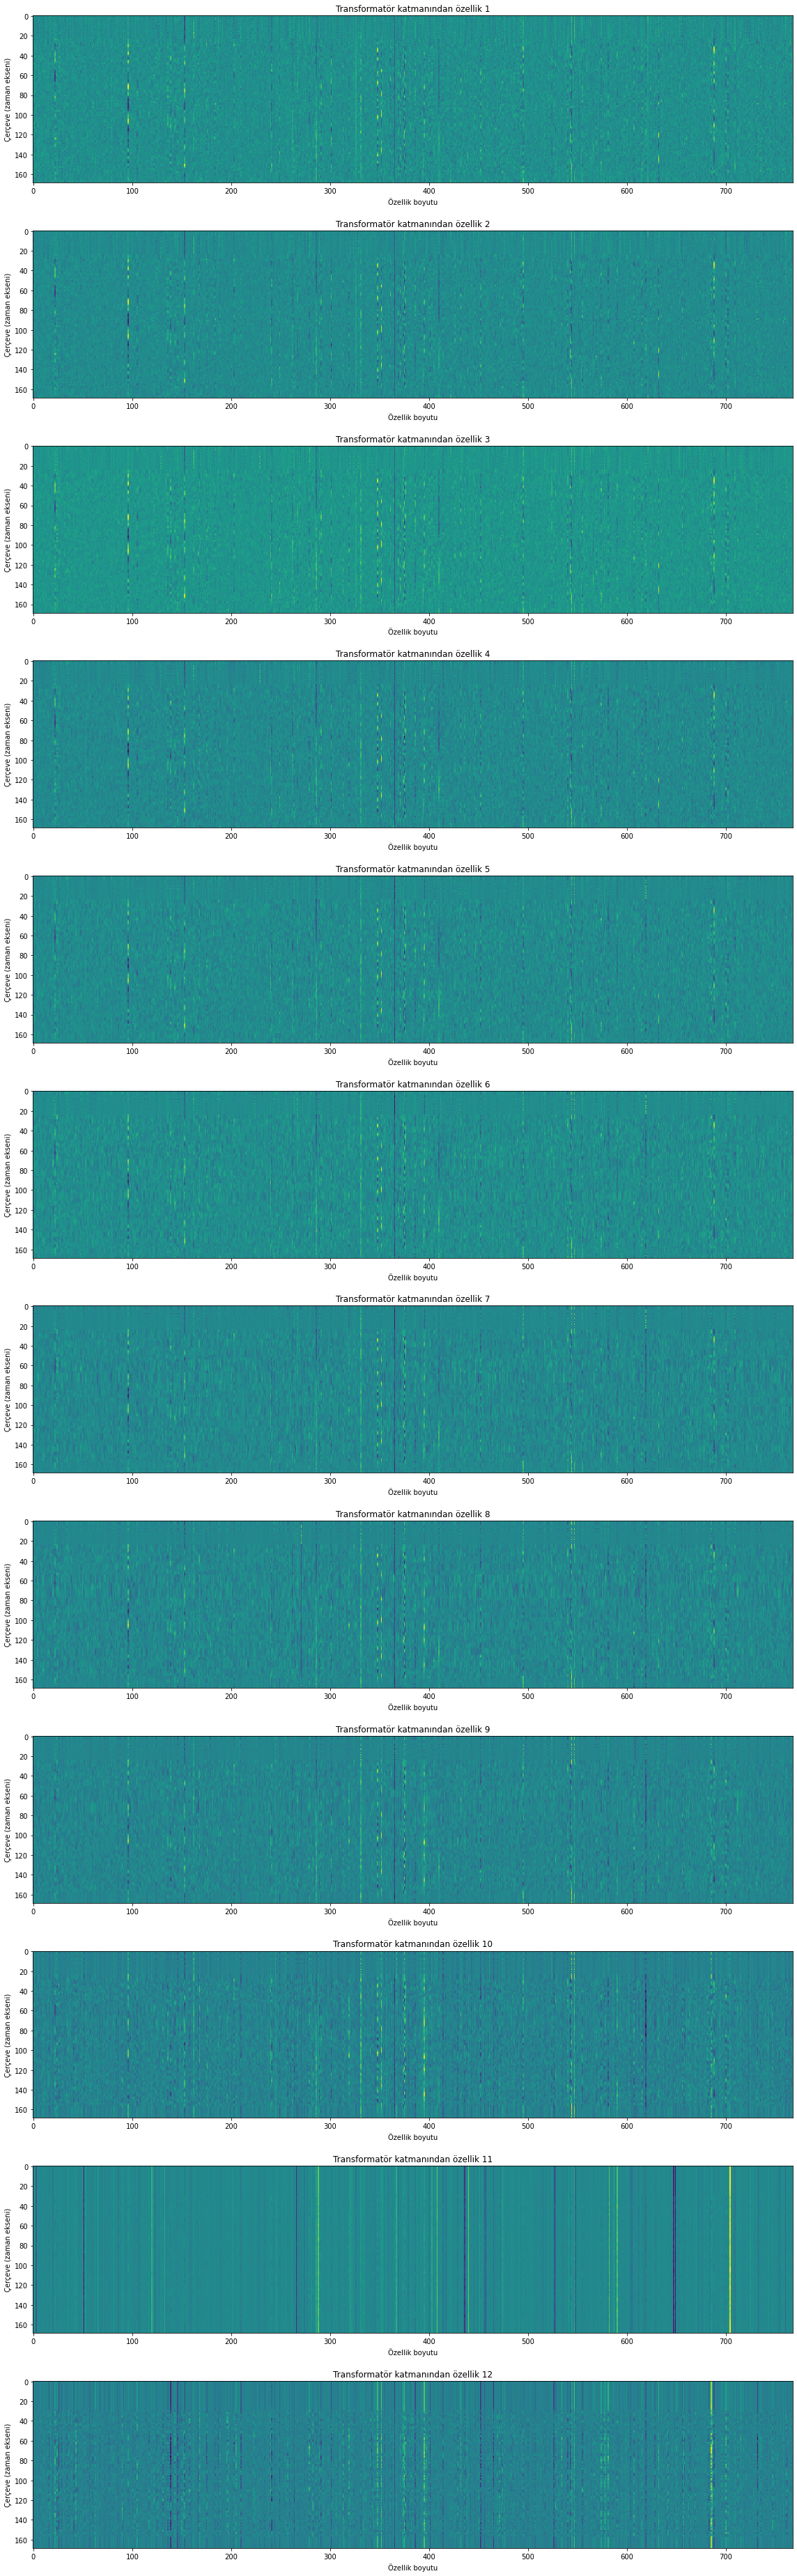

In [9]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Transformatör katmanından özellik {i+1}")
    ax[i].set_xlabel("Özellik boyutu")
    ax[i].set_ylabel("Çerçeve (zaman ekseni)")
plt.tight_layout()
plt.show()

## Özellik sınıflandırması

Akustik özellikler çıkarıldıktan sonra, bir sonraki adım sınıflandırmaktır.
Onları bir dizi kategoriye ayırır.

Wav2Vec2 modeli, özellik çıkarımı gerçekleştirmek için tek adımda sınıflandırma yöntemi sağlar.



In [10]:
with torch.inference_mode():
    emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of
probability.

Let’s visualize this.




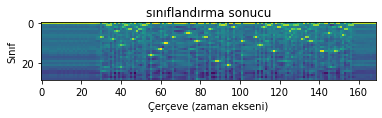

Sınıf etiketleri: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [11]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("sınıflandırma sonucu")
plt.xlabel("Çerçeve (zaman ekseni)")
plt.ylabel("Sınıf")
plt.show()
print("Sınıf etiketleri:", bundle.get_labels())

Zaman çizgisi boyunca belirli etiketlere yönelik güçlü göstergeler olduğunu görebiliriz.


## Transkript oluşturma

Etiket olasılıkları dizisinden, transkriptler oluşturmak istiyoruz.
Hipotez üretme süreci genellikle
"kod çözme"/ "decoding" olarak adlandırılır.

Kod çözme, basit sınıflandırmadan daha ayrıntılıdır çünkü
Belirli bir zaman adımındaki kod çözme, çevreden etkilenebilir.

Örneğin birbirine benzeyen kelimelerin geçtiği seste decoder doğru bir cümle kurabilmesi için yeterli bağlam görene kadar nihai kararı ertelemek zorunda kalır.

Önerilen birçok kod çözme tekniği vardır ve bunlar haricinde
kelime sözlüğü ve dil modelleri gibi kaynaklar kullanılabilir.

Bu eğitimde, basitlik adına, harici bileşenlere bağlı olmayan
her zaman adımında en iyi hipotezi seçerek ve bağlam
bilgilerini kullanmadan yalnızca bir transkript oluşturacağız.

Decoder algoritmamızı tanımlayalım.




In [12]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Etiketler üzerinden bir dizi tensör verildiğinde, en iyi yol dizesini elde edin
           emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.
           dönen değer:
           str: ortaya çıkacak olan transkript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

Şimdi kod çözücü nesnesini oluşturun ve transkriptin kodunu çözün.




In [13]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

Sonucu kontrol edelim ve sesi tekrar dinleyelim.




In [14]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


ASR modeli, Connectionist Temporal Classification (CTC) adı verilen bir kayıp işlevi kullanılarak ince ayarlanmıştır.
[tam belge](https://distill.pub/2017/ctc/).

## Özellik çıkarımının kısa yolu nasıldı derseniz?

   model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
   emission = model(waveforms, ...)


